In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os, sys
import time

from stn import spatial_transformer_network as stn_transformer

In [2]:
import Utility
import LoggerTest

In [3]:
dataName = 'Rot_NIST'

In [4]:
imgsTrainFile = 'Data/RotNIST_ImgsTrain.npy'
labelsTrainFile = 'Data/RotNIST_LabelsTrain.npy'

imgsValiFile = 'Data/RotNIST_ImgsVali.npy'
labelsValiFile = 'Data/RotNIST_LabelsVali.npy'

In [5]:
imgsTrain = np.load(imgsTrainFile)
labelsTrain = np.load(labelsTrainFile)


In [6]:
randSeed = 123456
np.random.seed(randSeed)
indicesTrain = list(range(imgsTrain.shape[0]))
np.random.shuffle(indicesTrain)

In [7]:
imgsTrain = imgsTrain[indicesTrain,:,:]
labelsTrain = labelsTrain[indicesTrain, :]

In [8]:
imgsTrain.shape

(275000, 28, 28, 1)

In [9]:
labelsTrain.shape

(275000, 10)

In [10]:
imgsTest = np.load(imgsValiFile)
labelsTest = np.load(labelsValiFile)

In [11]:
imgsTest.shape

(25000, 28, 28, 1)

In [12]:
assert imgsTrain.shape[0] == labelsTrain.shape[0]
assert imgsTest.shape[0] == labelsTest.shape[0]

In [13]:
labelsTest.shape

(25000, 10)

Number corners: 275000


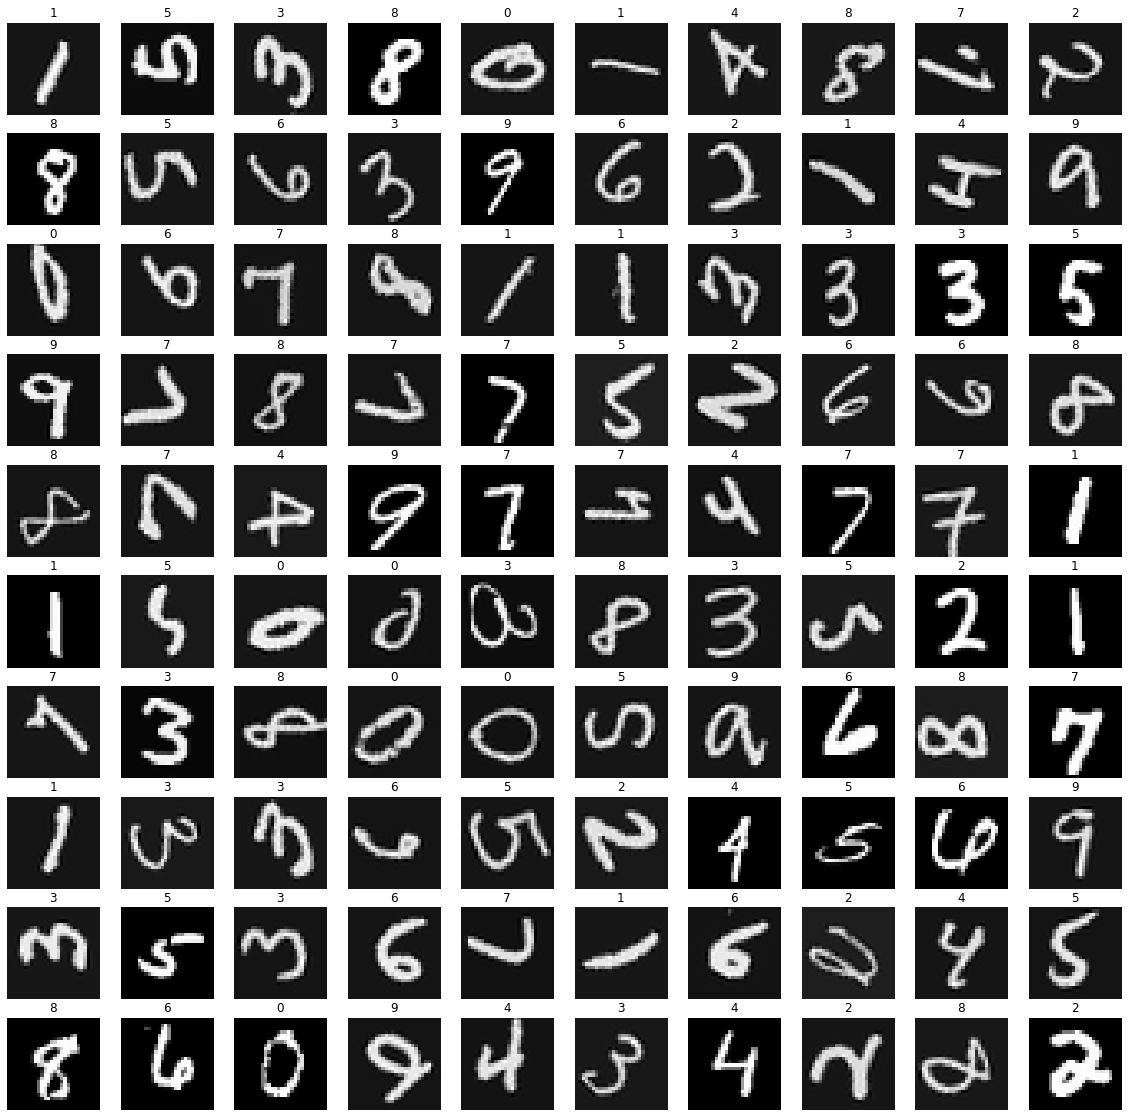

In [14]:
Utility.visualizeAugData(imgsTrain, labelsTrain)

Number corners: 25000


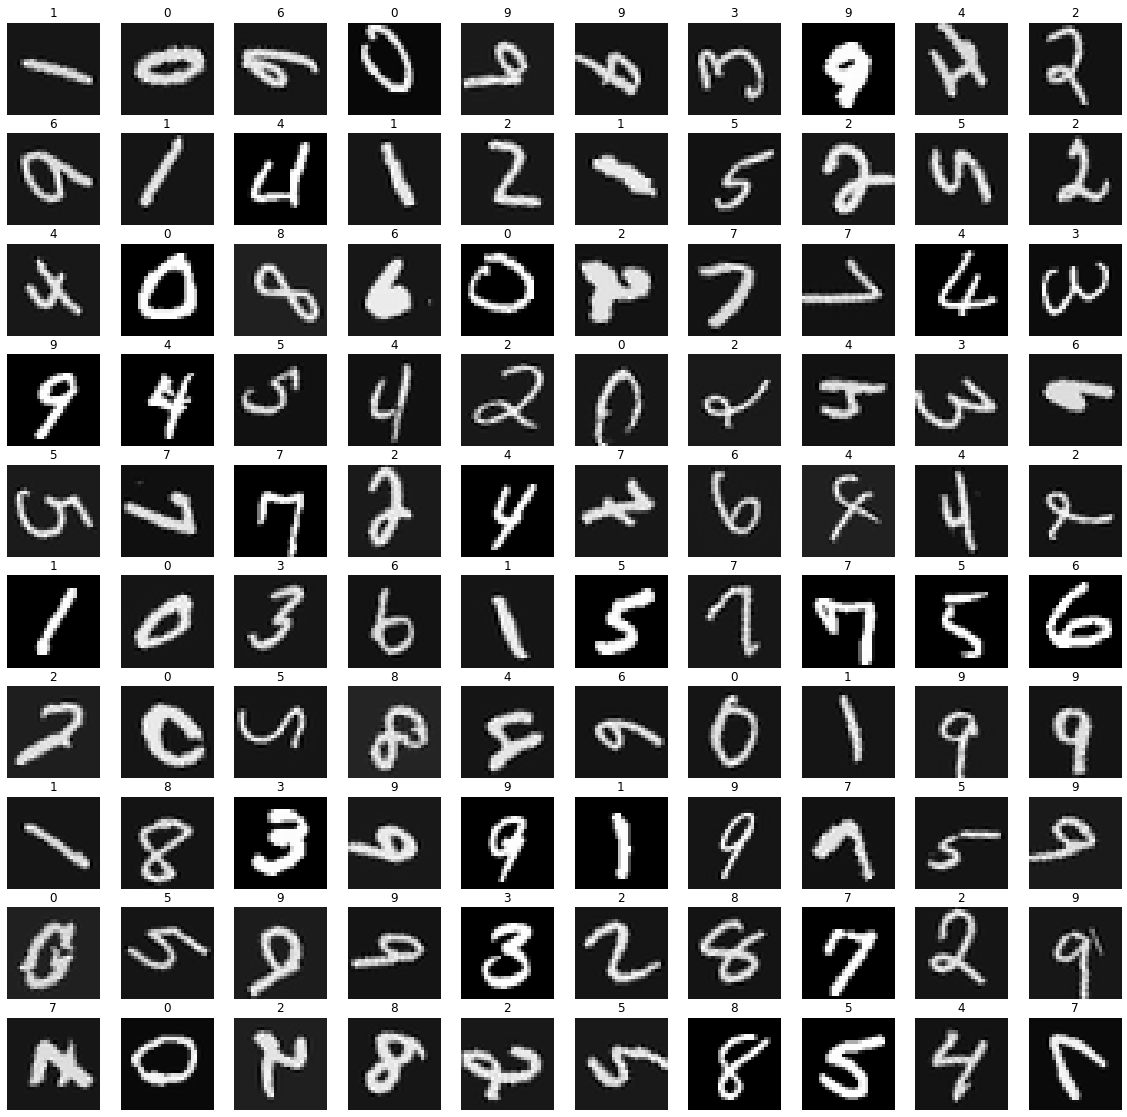

In [15]:
Utility.visualizeAugData(imgsTest, labelsTest)

In [16]:
tf.reset_default_graph()

x_image=tf.placeholder(tf.float32,[None,28, 28, 1], name='x_image')

# CNN to get stn parameters
convSizes = [3,3,3]
convChannels = [32, 64, 128]
maxPoolingPosition = [0,1,2]

convLayer, ws, bs = Utility.getConvLayers(x_image, 1, convSizes, convChannels, maxPoolingPosition, padding='SAME', netName='stn')
        
print(convLayer.get_shape())
flattenSize = Utility.getFlattenSize(convLayer)
print(flattenSize)
flat = tf.reshape(convLayer, [-1, flattenSize])
W_fc_STN = tf.Variable(tf.zeros([2048, 6]), name='W_fc_STN')
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32').flatten()
b_STN = tf.Variable(initial_value=initial, name='b_STN')
x = tf.matmul(flat, W_fc_STN) + b_STN

transformed_image = stn_transformer(x_image, x, [28,28,1])


ys=tf.placeholder(tf.float32,[None,10], 'ys')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

W_conv1=Utility.weight_variable([5,5,1,32])
b_conv1=Utility.bias_variable([32])

h_conv1=tf.nn.relu(Utility.conv2d(transformed_image,W_conv1)+b_conv1)
h_pool1=Utility.max_pool_2x2(h_conv1)

W_conv2=Utility.weight_variable([5,5,32,64])
b_conv2=Utility.bias_variable([64])

h_conv2=tf.nn.relu(Utility.conv2d(h_pool1,W_conv2)+b_conv2)
h_pool2=Utility.max_pool_2x2(h_conv2)

h_pool2_flat=tf.reshape(h_pool2,[-1,7*7*64])

W_fc1=Utility.weight_variable([7*7*64,1024])
b_fc1=Utility.bias_variable([1024])

h_fc1=tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1)+b_fc1)
h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)

W_fc2=Utility.weight_variable([1024,10])
b_fc2=Utility.bias_variable([10])

prediction = tf.nn.softmax(tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2))
cross_entropy=tf.reduce_mean(
    -tf.reduce_sum(ys*tf.log(prediction),
    reduction_indices=[1]))

train_step=tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 4, 4, 128)
(?, 4, 4, 128)
2048


In [17]:
sess = tf.Session()


In [18]:
init = tf.global_variables_initializer()
sess.run(init)

In [19]:
from Utility import compute_accuracy

In [24]:
logger = LoggerTest.configLogger("Log/STN_CNN" + dataName + ".txt", logFileMode='a')


In [25]:
accTrain = []
accTest = []
batchSize = 8000
# if readWeights:
#     saver = tf.train.Saver()
#     saver.restore(sess, "save/model.ckpt")
# else:
    
print(Utility.compute_accuracy(
           imgsTest[:1000], labelsTest[:1000], prediction, sess))

timeStart = time.clock()


numEpoch = 400
printStep = 5
numBatchs = int(np.ceil(imgsTrain.shape[0] / batchSize))
for iEpoch in range(numEpoch):
    for iBatch in range(numBatchs):
        batchData = imgsTrain[iBatch*batchSize:(iBatch+1)*batchSize]
        gdData = labelsTrain[iBatch*batchSize:(iBatch+1)*batchSize, :]
        
        sess.run(train_step, feed_dict={x_image: batchData, ys: gdData, keep_prob: 0.65})
    
    if iEpoch % printStep == 0:
        accTrain.append(Utility.compute_accuracy(imgsTrain,
                                     labelsTrain, prediction, sess))
        accTest.append(Utility.compute_accuracy(
            imgsTest, labelsTest, prediction, sess))
        
        infoStr = "Epoch: {:3d} Train accuracy: {:.6f} Test accuracy: {:.6f} Loss on Train batch: {:02.4f} time {:05.2f}".format(
            iEpoch, accTrain[-1], accTest[-1], sess.run(cross_entropy,feed_dict={x_image: batchData, ys: gdData, keep_prob: 1.0}),
            time.clock()-timeStart
        ) 
        logger.info(infoStr)


In [ ]:
os.makedirs("save", exist_ok=True)
saver = tf.train.Saver()
saver_path = saver.save(sess, "save/modelCNN_stn.ckpt")

0.124


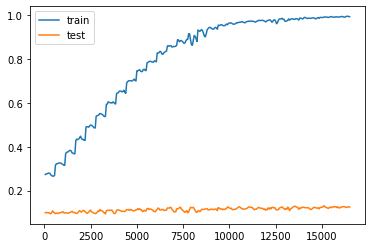

In [36]:
fig, axs = plt.subplots()
x = [(i+1)*50 for i in range(len(accTrain))]

axs.plot(x, accTrain, label='train')
x = [(i+1)*50 for i in range(len(accTest))]
axs.plot(x, accTest, label='test')
axs.legend()
fig.savefig("lossCNN_Aug.pdf", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

print(compute_accuracy(
    imgsTest[:1000], labelsTest[:1000]))